참고  
https://www.kaggle.com/code/jamesnrobertson/brain-tumor-transfer-learning-vgg16-98-acc

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms, models
from torchvision.io import read_image
import numpy as np
import time

In [2]:
import os
os.remove("../Brain_Tumor_MRI/data.csv")

# Labeling

In [3]:
import csv


tumors = ["glioma_tumor", "meningioma_tumor", "pituitary_tumor"]
tumor_to_label = {"Normal": 0, "glioma_tumor": 1, "meningioma_tumor": 2, "pituitary_tumor": 3}


with open("data.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow(["img", "label"])
    for tumor_folder in tumors:
        for image in os.listdir(f"../../Data/Brain Tumors MRI Dataset/Tumor/{tumor_folder}"):
            writer.writerow([f"Tumor/{tumor_folder}/{image}", tumor_to_label[tumor_folder]])
                
    for image in os.listdir(f"../../Data/Brain Tumors MRI Dataset/Normal"):
            writer.writerow([f"Normal/{image}", tumor_to_label["Normal"]])

# Dataset

In [4]:
# writing dataloader class for the dataset

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.annotations = pd.read_csv("../Brain_Tumor_MRI/data.csv")
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return (image, y_label)

In [5]:
a = pd.read_csv("../Brain_Tumor_MRI/data.csv")
print(a.head())
print(len(a))

                                img  label
0        Tumor/glioma_tumor/G_1.jpg      1
1       Tumor/glioma_tumor/G_10.jpg      1
2      Tumor/glioma_tumor/G_100.jpg      1
3  Tumor/glioma_tumor/G_100_BR_.jpg      1
4  Tumor/glioma_tumor/G_100_DA_.jpg      1
21672


# Image Transform

In [6]:
# getting the dataset in and splitting it and applying transforms

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.CenterCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


dataset = BrainTumorDataset(root_dir="../../Data/Brain Tumors MRI Dataset/", csv_file="../Brain_Tumor_MRI/data.csv")

train_data, test_data = torch.utils.data.random_split(dataset, [0.7, 0.3])
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


### set the loaders


In [8]:
# set the loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
)

# Model

In [9]:
# Define the model and freeze the weights
model = models.vgg16(pretrained=True)


for param in model.parameters():
  param.requires_grad = False

c:\Users\cmsk6\miniconda3\envs\MathAI\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cmsk6\miniconda3\envs\MathAI\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# setting the head up
n_features = model.classifier[0].in_features
model.classifier = nn.Linear(n_features, 4)

In [11]:
# sending the model to the device and choosing the criterion and optimizer
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [12]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Training

In [13]:
# training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = time.perf_counter()
        train_loss = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        
        train_loss = np.mean(train_loss)

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        
        test_loss = np.mean(test_loss)

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        t1 = time.perf_counter()

        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {(t1 - t0):.4f}')

    return train_losses, test_losses

In [14]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, 5)

Epoch 1/5, Train Loss: 0.5140, Test Loss: 0.3897, Duration: 721.3136
Epoch 2/5, Train Loss: 0.1443, Test Loss: 0.3582, Duration: 158.3656
Epoch 3/5, Train Loss: 0.0723, Test Loss: 0.3408, Duration: 158.6027
Epoch 4/5, Train Loss: 0.0536, Test Loss: 0.3686, Duration: 158.4129
Epoch 5/5, Train Loss: 0.0417, Test Loss: 0.4466, Duration: 158.6154


### loss

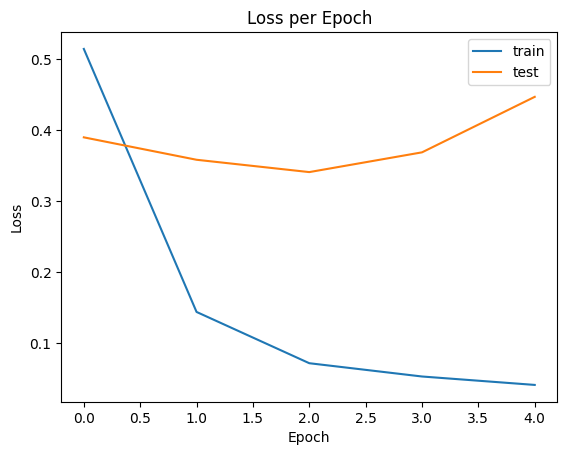

In [15]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### Evaluation

In [16]:
model.eval()
n_correct = 0.
n_total = 0.

for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)

    _, predictions = torch.max(outputs, 1)

    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)

    _, predictions = torch.max(outputs, 1)

    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train Acc: {train_acc}, Test Acc: {test_acc}")

Train Acc: 0.9796981082328126, Test Acc: 0.9601328903654485


In [17]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [18]:
print(test_data)

Confusion matrix, without normalization
[[ 931    4   21    7]
 [  30 1593  307    9]
 [  21   49 1782   31]
 [   6    6   65 1639]]


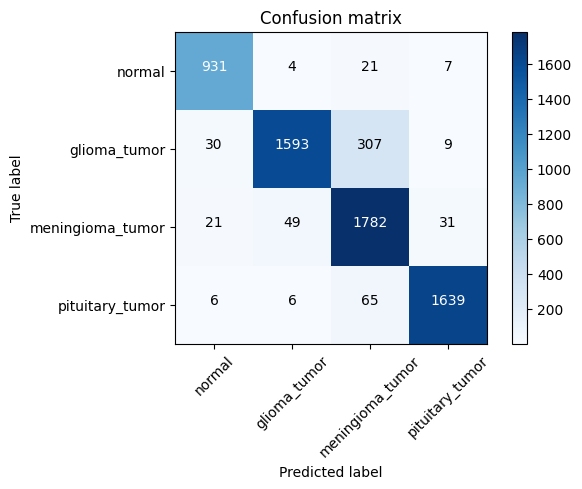

In [19]:
import itertools

y_test = []
for _, label in test_loader:
    y_test.append(label.cpu().tolist())

y_test = list(itertools.chain.from_iterable(y_test))
p_test = np.array([])

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)

    _, predictions = torch.max(outputs, 1)

    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, ["normal", "glioma_tumor", "meningioma_tumor", "pituitary_tumor"])